## Reading Dataset and Preparing it.

In [36]:
#Import Libraries
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import datetime
import warnings 
import jalali_pandas
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,MinMaxScaler
warnings.filterwarnings('ignore')

In [37]:
df = pd.read_csv(r"C:\Users\snapp\Desktop\AI\Digikala\Dataset.csv",index_col='Unnamed: 0')
df.sample(4)

,CustomerID,OrderID,Date,Revenue
258865,3344279,58104466,20200413,3160
226871,15476347,52646422,20200215,276
89340,13564681,42205442,20190928,4220
21484,6882788,36788434,20190622,1560


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261960 entries, 0 to 261959
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   CustomerID  261960 non-null  int64
 1   OrderID     261960 non-null  int64
 2   Date        261960 non-null  int64
 3   Revenue     261960 non-null  int64
dtypes: int64(4)
memory usage: 10.0 MB


In [39]:
df.describe()

,CustomerID,OrderID,Date,Revenue
count,2.619600e+05,2.619600e+05,2.619600e+05,261960.000000
mean,7.169337e+06,4.526490e+07,2.019366e+07,6109.570595
std,4.957141e+06,6.121027e+06,4.237757e+03,5646.762773
min,4.651320e+05,3.293076e+07,2.019032e+07,106.000000
25%,3.267469e+06,4.006175e+07,2.019082e+07,2451.000000
50%,6.663396e+06,4.479244e+07,2.019111e+07,5100.000000
75%,1.122706e+07,5.004593e+07,2.020012e+07,7960.000000
max,4.654955e+07,5.885319e+07,2.020042e+07,175200.000000


In [40]:
# convert Date field to jalali_date
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df['jdate'] = df['Date'].jalali.to_jalali()
df['year'] = df['jdate'].jalali.year
df['month'] = df['jdate'].jalali.month
df['day'] = df['jdate'].jalali.day

In [41]:
#Check Duplicate Values in Data
df.duplicated().sum()

0

## Question 1: N of customers, orders, AVG Order Value, AVG Frequency, Total revenue 

In [42]:
# Preparing Data
gr = df[df['year']==1398].groupby('month').agg({'CustomerID':'nunique',
                                           'OrderID':'count',
                                           'Revenue':['mean','sum'],
                                          }).round(2)
gr.columns = gr.columns.get_level_values(1)
gr.reset_index(inplace = True)
gr.rename(columns = {'nunique':'unique_customer',
                     'count':'count_order',
                     'mean':'avg_order_value',
                     'sum':'revenue'},inplace = True )
gr['avg_Frequency']=round(gr['count_order']/gr['unique_customer'],2)

In [43]:
gr

,month,unique_customer,count_order,avg_order_value,revenue,avg_Frequency
0,1,2789,3279,5983.07,19618499,1.18
1,2,3064,3503,6811.41,23860379,1.14
2,3,12768,14380,6353.51,91363493,1.13
3,4,14122,16228,6615.14,107350424,1.15
4,5,24708,28663,5111.21,146502637,1.16
5,6,16603,18630,5602.55,104375481,1.12
6,7,22541,26699,5641.54,150623504,1.18
7,8,28594,33233,5506.90,183010916,1.16
8,9,27344,30989,5821.10,180390183,1.13
9,10,23048,26642,6658.94,177407408,1.16


## Question 2: Month with Highest Order and Revenue

In [44]:
max_revenue = gr.sort_values(['revenue'], ascending=[False])
max_revenue.iloc[0,0]

8

In [45]:
max_order = gr.sort_values(['count_order'], ascending=[False])
max_order.iloc[0,0]

8

## Question 3: RFM Segmentation with KMEANS

In [46]:
max_date=df.sort_values(['Date'],ascending=False).iloc[0,2]
min_date = max_date - timedelta(days=180)

In [47]:
Data = df[(df['Date']<=max_date) & (df['Date']>=min_date)]
Data.head()

,CustomerID,OrderID,Date,Revenue,jdate,year,month,day
110985,9712668,43649549,2019-10-22,3120,1398-07-30 00:00:00,1398,7,30
110986,7419968,43646459,2019-10-22,4400,1398-07-30 00:00:00,1398,7,30
110987,13911230,43691117,2019-10-22,4400,1398-07-30 00:00:00,1398,7,30
110988,1415487,43708002,2019-10-22,4400,1398-07-30 00:00:00,1398,7,30
110989,5801238,43669111,2019-10-22,1560,1398-07-30 00:00:00,1398,7,30


In [48]:
#Prepare Data For RFM Segmentaion
Data= Data.groupby('CustomerID').agg({'OrderID':'count','Revenue':'sum','Date':'max'}).reset_index()

In [49]:
#Create a column for Recency
Data['Recency']=(max_date-Data['Date']).dt.days
Data.rename(columns = {'OrderID':'Frequency','Revenue':'Monetory','Recency':'Recency'},inplace = True)

In [50]:
#Drop Extra Column
Data.drop(['Date'],axis =1,inplace=True)

In [51]:
Data.tail()

,CustomerID,Frequency,Monetory,Recency
112335,46144731,1,2360,108
112336,46188806,1,9160,151
112337,46380582,1,13520,22
112338,46518839,1,54360,49
112339,46538916,1,9160,11


In [52]:
#Scale Data with MinMax Scaler
scaler = MinMaxScaler()
Data[['Frequency', 'Monetory','Recency']] = scaler.fit_transform(Data[['Frequency', 'Monetory','Recency']])

In [53]:
Data_model = Data[['Frequency', 'Monetory','Recency']]
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Data_model)
    Sum_of_squared_distances.append(km.inertia_)

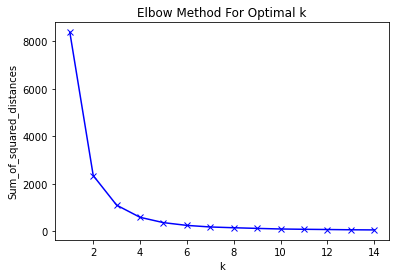

In [54]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

##### The best number of Cluster based on Elbow Method is 4 

In [55]:
Data_model = Data[['Frequency', 'Monetory','Recency']]
model = KMeans(n_clusters = 4)
model = model.fit(Data_model)

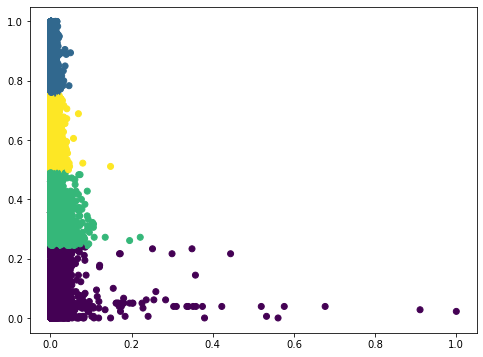

In [56]:
# Two Dimention plot
plt.figure(figsize =(8,6))
plt.scatter(Data_model.iloc[:,1],Data_model.iloc[:,2], c=model.labels_.astype(np.float))
plt.show()

Text(0.5, 0.92, 'simple 3D scatter plot')

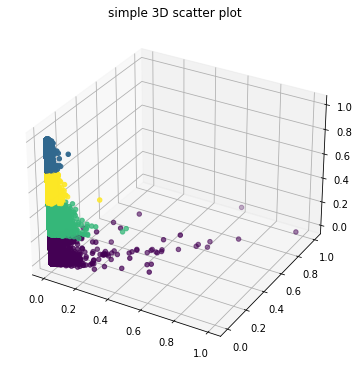

In [57]:
# Tree Dimention plot 
fig = plt.figure(figsize = (6, 8))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(xs=Data_model.iloc[:,0],
             ys=Data_model.iloc[:,1],
             zs=Data_model.iloc[:,2],
             c=model.labels_.astype(np.float))
plt.title("simple 3D scatter plot")

In [58]:
#Add Label to Data
Data['Labels'] = model.labels_

In [59]:
# Inverse Data from Scaler
Data[['Frequency']]=scaler.inverse_transform(Data[['Frequency', 'Monetory','Recency']])[:, [0]]
Data[['Monetory']]=scaler.inverse_transform(Data[['Frequency', 'Monetory','Recency']])[:, [1]]
Data[['Recency']]=scaler.inverse_transform(Data[['Frequency', 'Monetory','Recency']])[:, [2]]

In [60]:
Data.sample(4)

,CustomerID,Frequency,Monetory,Recency,Labels
88210,12901394,1.0,1076.0,61.0,2
90289,13266116,1.0,4360.0,85.0,2
21995,2921256,1.0,697.0,155.0,1
90602,13317070,1.0,5100.0,121.0,3


In [61]:
Data.groupby('Labels').agg({'CustomerID':'count',
                            'Frequency':'mean',
                            'Monetory':'mean',
                            'Recency':'mean'}).reset_index().sort_values(['Frequency', 'Monetory','Recency'],ascending=[False,False,True])

,Labels,CustomerID,Frequency,Monetory,Recency
0,0,15560,1.844280,15041.443123,19.165296
2,2,32572,1.501075,9375.633919,66.993461
3,3,32029,1.203971,7000.179556,111.934434
1,1,32179,1.082165,6066.946953,158.595544


## Question 4: CLV Calculation

In [62]:
ARPU_data= df.groupby('CustomerID').agg({'Revenue':'sum','jdate':'min','OrderID':'count'}).reset_index()

In [63]:
ARPU_data['year'] = ARPU_data['jdate'].jalali.year
ARPU_data['month'] = ARPU_data['jdate'].jalali.month
ARPU_data=ARPU_data[ARPU_data['month']==1]

In [64]:
#Calculate ARPU
ARPU = ARPU_data['Revenue'].sum()/ARPU_data['CustomerID'].nunique()

In [65]:
ARPU_data['current']=df['jdate'].max()
ARPU_data['delta_day'] = (ARPU_data['current']-ARPU_data['jdate']).dt.days

In [66]:
# Calculate Churn Rate
churn_customer = ARPU_data[ARPU_data['delta_day']>365]['CustomerID'].count()
churn_rate = churn_customer/(ARPU_data['CustomerID'].count())

In [67]:
round(churn_rate*100,2)

22.36

In [68]:
# Calculate CLV
CLV = ARPU/churn_rate
CLV

40734.38212634823